# Manufacturing Quality Control With Control Charts
Problem:
A factory tracks defect rates on an assembly line and needs to detect shifts in quality.
- Ingest daily sample defect counts and sample sizes
- Compute daily defect proportion p,build controlcharts(p-chart) with 3sigma limits.
- Use hypothesis tests to flag days where defect proportion exceeds expected bounds.
- Analyze run length and propose corrective actions based on detected shifts.

In [ ]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


 It creates 60 days of data from Jan 1, 2024. Each day gets a random sample size (80–120) and defects are simulated using a 5% defect rate. It then stores the data in a DataFrame and calculates the daily defect rate as defects ÷ sample size.


###simulate 60 days of defect data

In [ ]:
np.random.seed(42)

In [ ]:
days=pd.date_range(start='2023-01-01',periods=60)
sample_size=np.random.randint(low=80,high=120,size=60)

In [ ]:
true_defect_rate=0.05 #sets the true defect rate to 5%

In [ ]:
defect_count=np.random.binomial(n=sample_size,p=true_defect_rate)

In [ ]:
df=pd.DataFrame({'Date':days,'Sample_Size':sample_size,'Defect_Count':defect_count})

In [ ]:
df['Defect_Rate']=df['Defect_Count']/df['Sample_Size']

In [ ]:
df.head()

,Date,Sample_Size,Defect_Count,Defect_Rate
0,2023-01-01,118,5,0.042373
1,2023-01-02,108,9,0.083333
2,2023-01-03,94,6,0.063830
3,2023-01-04,87,3,0.034483
4,2023-01-05,100,5,0.050000


## What is p-chart
A p-chart(proportion chart) is used in statistical quality control to monitor the proportion of defective units in a process when sample size may vary from day to day.
This value (p_bar) acts like a baseline or centerline on the p-chart. The same value is added as a new column in the DataFrame so it can be used in later calculations like setting control limits.

In [ ]:
#overall avg defect rate
p_bar=df['Defect_Count'].sum()/df['Sample_Size'].sum()

In [ ]:
# Control limits (3sigma)
df['p_bar'] = p_bar

In [ ]:
df['UCL']=p_bar+3*np.sqrt(p_bar*(1-p_bar)/df['Sample_Size']) #upper control limit
df['LCL']=p_bar-3*np.sqrt(p_bar*(1-p_bar)/df['Sample_Size']) #lower control limit
df.head()

,Date,Sample_Size,Defect_Count,Defect_Rate,p_bar,UCL,LCL
0,2023-01-01,118,5,0.042373,0.052011,0.113336,-0.009313
1,2023-01-02,108,9,0.083333,0.052011,0.116112,-0.012089
2,2023-01-03,94,6,0.063830,0.052011,0.120720,-0.016697
3,2023-01-04,87,3,0.034483,0.052011,0.123430,-0.019407
4,2023-01-05,100,5,0.050000,0.052011,0.118626,-0.014604


In [ ]:
df['LCL']=df['LCL'].clip(lower=0)#LCL cant be negative

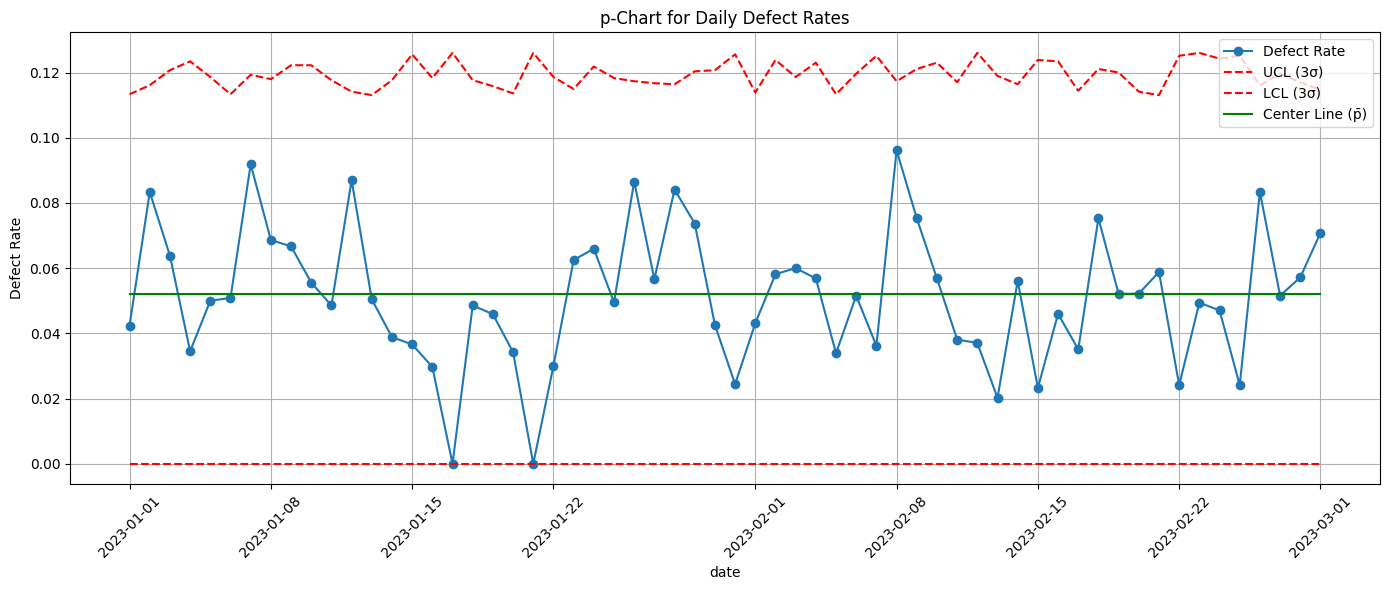

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')
plt.title("p-Chart for Daily Defect Rates")
plt.xlabel('date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Is my process producing defects at a consistent and acceptable level?         

we can use a p-chart, which helps monitor the proportion of defective units over time. By plotting daily defect rates against control limits, the p-chart reveals whether the process is stable or if there are signs of unexpected variation that may require investigation.


##Flag out-of-control Points
we are trying to flag the days where the defect rate is too high or too low- that is,outside the expected control limits on our p-chart

In [ ]:
df['out_of_control']=(df['Defect_Rate']>df['UCL'])|(df['Defect_Rate']<df['LCL'])
# true- if that day is out of control
# false- if the defect rate is within limits
print(df.head())
print(df[df['out_of_control']][['Date','Defect_Rate','UCL','LCL']]) # filter out of control=true

        Date  Sample_Size  Defect_Count  Defect_Rate     p_bar       UCL  LCL  \
0 2023-01-01          118             5     0.042373  0.052011  0.113336  0.0   
1 2023-01-02          108             9     0.083333  0.052011  0.116112  0.0   
2 2023-01-03           94             6     0.063830  0.052011  0.120720  0.0   
3 2023-01-04           87             3     0.034483  0.052011  0.123430  0.0   
4 2023-01-05          100             5     0.050000  0.052011  0.118626  0.0   

   defects  defect_rate  out_of_control  ...  Day  Trend_Line  CUSUM_pos  \
0      NaN          NaN           False  ...    1    0.053057   0.000000   
1      NaN          NaN           False  ...    2    0.052994   0.027126   
2      NaN          NaN           False  ...    3    0.052932   0.034748   
3      NaN          NaN           False  ...    4    0.052869   0.013024   
4      NaN          NaN           False  ...    5    0.052806   0.006816   

   CUSUM_neg  Signal      EWMA  UCL_EWMA  LCL_EWMA  CUSU

## Hypothesis Testing Example(One proportion Z-test)

using hypothesis testing, specifically the One Proportion Z-test, to statistically check whether a specific day's defect rate is significantly higher than usual.


In [ ]:
from statsmodels.stats.proportion import proportions_ztest
#understand most defect are above the 0.5 per threshold
#test if last day's defect rate is significantly higher then average
last=df.iloc[-1]
count=last['Defect_Count']
nobs=last['Sample_Size']
stat,pval=proportions_ztest(count,nobs,value=p_bar,alternative='larger')
if pval<0.05:
  print("Reject the null hypothesis")
else:
  print("Fail to reject the null hypothesis")

Fail to reject the null hypothesis


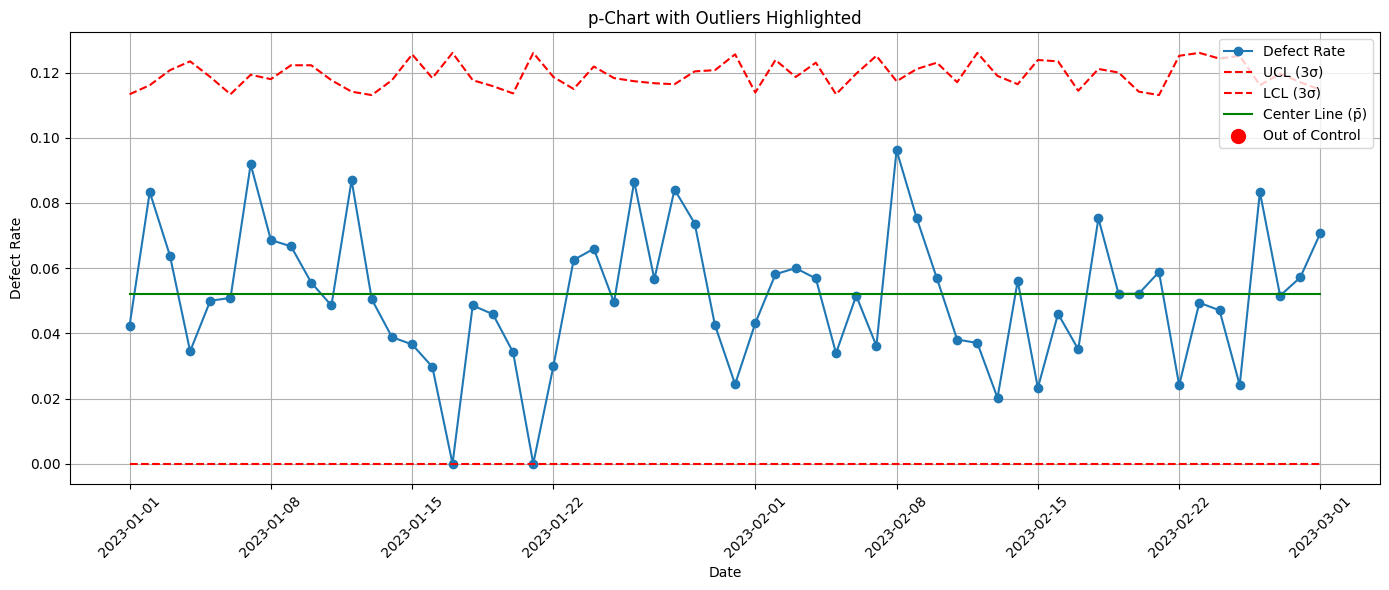

In [ ]:
#mark control points on chart
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defect_Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3σ)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3σ)')
plt.plot(df['Date'],df['p_bar'],linestyle='-',color='green',label='Center Line (p̄)')

#highlight points
out=df[df['out_of_control']]
plt.scatter(out['Date'],out['Defect_Rate'],color='red',s=100,label='Out of Control')
plt.title("p-Chart with Outliers Highlighted")
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## What is a process shift?
A process shift is a change in how a process behaves over time, often leading to lower quality. It happens when something causes the defect rate or output to move away from the normal, expected range. This usually results in more errors or off-target results.

## Everyday Analogy
Imagine a coffee machine that normally fills cups with 200 ml. One day, it starts filling 220 ml instead. The machine still works, but its behavior has changed — that’s a process shift.

###Introduce a shift in the defect rate on day 35

In [ ]:
df.loc[35:,'defects']=np.random.binomial(df.loc[35:,'Sample_Size'],0.10) #doubled defect rate
df['defect_rate']=df['defects']/df['Sample_Size']
df.head()

,Date,Sample_Size,Defect_Count,Defect_Rate,p_bar,UCL,LCL,defects,defect_rate
0,2023-01-01,118,5,0.042373,0.052011,0.113336,0.0,NaN,NaN
1,2023-01-02,108,9,0.083333,0.052011,0.116112,0.0,NaN,NaN
2,2023-01-03,94,6,0.063830,0.052011,0.120720,0.0,NaN,NaN
3,2023-01-04,87,3,0.034483,0.052011,0.123430,0.0,NaN,NaN
4,2023-01-05,100,5,0.050000,0.052011,0.118626,0.0,NaN,NaN


In [ ]:
# Recalculate control limits based on the new p_bar
df['UCL'] = p_bar + 3 * np.sqrt(p_bar * (1 - p_bar) / df['Sample_Size'])
df['LCL'] = p_bar - 3 * np.sqrt(p_bar * (1 - p_bar) / df['Sample_Size'])
df['LCL'] = df['LCL'].clip(lower=0)

In [ ]:
#flag out of control points
df['out_of_control']=(df['Defect_Rate']>df['UCL'])|(df['Defect_Rate']<df['LCL'])
print(df[df['out_of_control']][['Date','Defect_Rate','UCL','LCL']])

Empty DataFrame
Columns: [Date, Defect_Rate, UCL, LCL]
Index: []


In [ ]:
df.head()

,Date,Sample_Size,Defect_Count,Defect_Rate,p_bar,UCL,LCL,defects,defect_rate,out_of_control
0,2023-01-01,118,5,0.042373,0.052011,0.113336,0.0,NaN,NaN,False
1,2023-01-02,108,9,0.083333,0.052011,0.116112,0.0,NaN,NaN,False
2,2023-01-03,94,6,0.063830,0.052011,0.120720,0.0,NaN,NaN,False
3,2023-01-04,87,3,0.034483,0.052011,0.123430,0.0,NaN,NaN,False
4,2023-01-05,100,5,0.050000,0.052011,0.118626,0.0,NaN,NaN,False


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Test if last day's defect rate is significantly higher than average
last = df.iloc[-1]
count = last['Defect_Count'] # Corrected column name
nobs = last['Sample_Size' ]

stat, pval = proportions_ztest(count, nobs, value=p_bar, alternative='larger' )
print(f"Z-stat: {stat:.2f}, p-value: {pval:.4f}")

Z-stat: 0.78, p-value: 0.2181


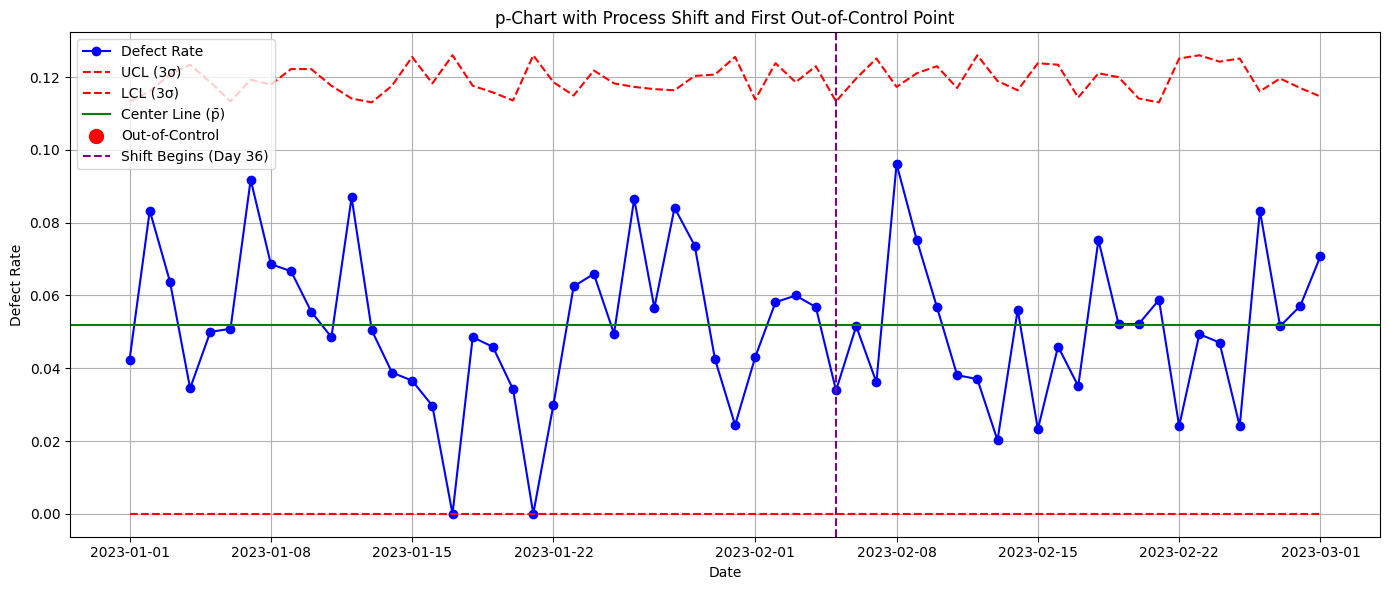

No significant shift detected.


In [ ]:
plt.figure(figsize=(14, 6))
# Defect Rate line - Use 'date' column for x-axis and 'Defect_rate' for y-axis
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate', color='blue')

# Control Limits - Use 'date' column for x-axis
plt.plot(df['Date'], df['UCL'], 'r--', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], 'r--', label='LCL (3σ)')
# The horizontal line for p_bar doesn't need 'date' column as it's constant
plt.axhline(p_bar, color='green', linestyle='-', label='Center Line (p̄)')

# Highlight out-of-control points - Use 'date' for x-axis and 'Defect_rate' for y-axis
plt.scatter(df[df['out_of_control']]['Date'], df[df['out_of_control']]['Defect_Rate'],
            color='red', label='Out-of-Control', zorder=5, s=100)

# Show vertical line for process shift - Need to define shift_day and use 'date' column
# Assuming shift_day is index 35 (the 36th day) based on the shift introduction code
shift_day = 35
plt.axvline(df.loc[shift_day, 'Date'], color='purple', linestyle='--',label=f'Shift Begins (Day {shift_day + 1})')
plt.title("p-Chart with Process Shift and First Out-of-Control Point")
plt.xlabel("Date")
plt.ylabel("Defect Rate")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
print("No significant shift detected.")

### Plot Explanation
This p-chart shows the daily defect rate over time. The green line is the average rate (center line), and the red dashed lines are control limits (±3σ). Blue dots show normal days, while red dots highlight out-of-control points. A purple line marks the day a process shift starts.


Here’s a cleaner and more concise version you can use:

---

## What are Run Rules in Quality Control?

Run rules are extra checks used with control charts (like p-charts) to spot early signs of process changes, even when points are still within control limits.

## Why are they needed?

Control limits catch big shifts, but run rules detect smaller, consistent changes before they become serious. They act as an early warning system for quality issues.


In [ ]:
#step 1: Estimate standard deviation for each row
df['sigma']=np.sqrt((df['p_bar']*(1-df['p_bar']))/df['Sample_Size'])

#step 2
df['Upper_1sigma']=df['p_bar']+df['sigma']
df['Lower_1sigma']=df['p_bar']-df['sigma']
df['Upper_2sigma']=df['p_bar']+(2*df['sigma'])
df['Lower_2sigma']=df['p_bar']-(2*df['sigma'])

# Rule 1 : If the defect rate on any day goes outside the 3-sigma limits (very far from normal), it’s a clear sign something’s off.
df['Rule1'] = (df['Defect_Rate' ] > df['UCL' ]) | (df['Defect_Rate'] < df['LCL' ])

# RULE 2: 2 of 3 consecutive points beyond 20 (same side)
rule2_flags = [False] * len(df)
for i in range(2, len(df)):
  upper = (df.loc[i-2:i, 'Defect_Rate'] > df.loc[i-2:i, 'Upper_2sigma' ]) .sum()
  lower = (df.loc[i-2:i, 'Defect_Rate'] < df.loc[i-2:i, 'Lower_2sigma' ]).sum()
  rule2_flags[i] = (upper >= 2) or (lower >= 2)
df['Rule2' ] = rule2_flags

In [ ]:
# RULE 3: 8 points in a row on same side of center line
df['Above_Center' ] = df['Defect_Rate' ] > df['p_bar' ]
run_lengths = [1]
for i in range(1, len(df)):
  if df.loc[i, 'Above_Center' ] == df.loc[i - 1, 'Above_Center' ]:
    run_lengths.append(run_lengths[-1] + 1)
  else:
    run_lengths.append(1)
df [ 'Run_Length' ] = run_lengths
df['Rule4'] = df['Run_Length' ] >= 8

In [ ]:
# Combine rules
df['Any_Rule_Violation' ] = df[ ['Rule1', 'Rule2' , 'Rule4']].any(axis=1)

# View violations
violations = df[df['Any_Rule_Violation' ]]
print(violations[['Date', 'Defect_Rate', 'Rule1', 'Rule2', 'Rule4' ]])

         Date  Defect_Rate  Rule1  Rule2  Rule4
19 2023-01-20     0.034188  False  False   True
20 2023-01-21     0.000000  False  False   True
21 2023-01-22     0.030000  False  False   True


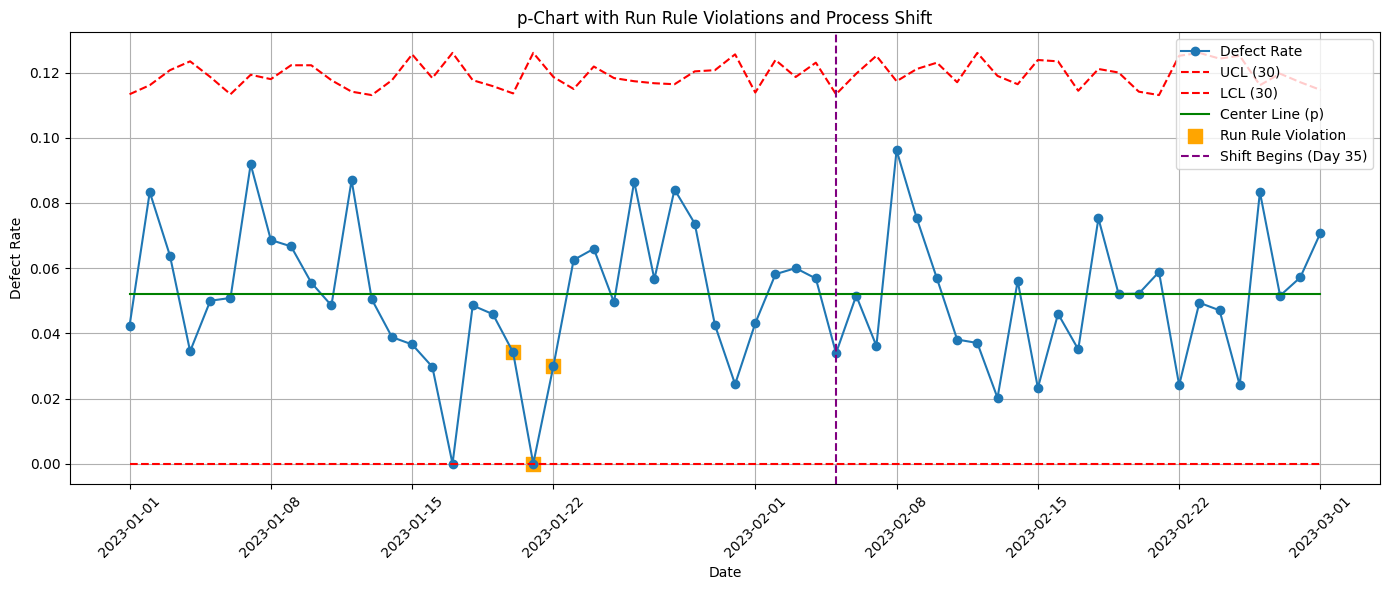

In [ ]:
# Plot with violations highlighted
plt.figure(figsize=(14, 6))

# Main defect rate line
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')

# Control limits and center
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (30)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (30)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p)')

# Highlight violations
plt.scatter(violations['Date'], violations['Defect_Rate'],
color='orange', s=100, marker='s', label='Run Rule Violation')

# Add shift marker
plt.axvline(df['Date'].iloc[35], color='purple', linestyle='--', label='Shift Begins (Day 35)')

# Final touches
plt.title('p-Chart with Run Rule Violations and Process Shift')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot Explanation
This p-chart shows the defect rate with control limits and run rule violations. Orange squares mark days that break run rules, even if they are within control limits. The purple line shows when a process shift began.

## What is Process Capability?

Process capability shows how well a process can meet customer limits. It tells if the process makes good parts consistently.

* **Cp** measures how wide the process is compared to limits (but not if it's centered).
* **Cpk** checks both spread and centering.

If **Cpk < Cp**, the process is not centered, increasing the chance of defects.


In [ ]:
LSL = 0.00

USL = 0.08

mu = df['Defect_Rate' ].mean()
sigma = df['Defect_Rate'].std()

Cp = (USL - LSL) / (6 * sigma)
Cpk = min((USL - mu) / (3 * sigma), (mu - LSL) / (3 * sigma))

print(f"Cp = {Cp : .2f}, Cpk = {Cpk : .2f}")

Cp =  0.64, Cpk =  0.46


In [ ]:
USL, LSL = 0.08, 0.02
#USL = Upper Specification Limit LSL = Lower Specification Limit
#This means the acceptable defect rate should stay between 2% and 8%.

process_sigma = df['Defect_Rate' ].std()
#Calculates the standard deviation of the process - that is, how much the daily defect rate varies.

In [ ]:
# Assume specs: acceptable defect rate between 2% and 8%
USL, LSL = 0.08, 0.02
process_sigma = df['Defect_Rate'].std()

Cp = (USL - LSL) / (6 * process_sigma)
Cpk = min((USL - p_bar), (p_bar - LSL)) / (3 * process_sigma)

print(f"Cp: {Cp : .2f}, Cpk: {Cpk : .2f}")

Cp:  0.48, Cpk:  0.45


## What is Bootstrapping?

Bootstrapping is a resampling method where we repeatedly take samples **with replacement** from the original data.

It helps estimate the uncertainty of a statistic (like mean or median) without needing strong assumptions. It's often used to create **confidence intervals** and measure **variability** in estimates.


In [ ]:
boot_means = [np.mean(np.random.choice(df['Defect_Rate'], size=len(df), replace=True)) for _ in range(1000)]

In [ ]:
ci_lower=np.percentile(boot_means,2.5)
ci_upper=np.percentile(boot_means,97.5)

print(f"95% CI for average defect rate: ({ci_lower : .4f}, {ci_upper : .4f})")

95% CI for average defect rate: ( 0.0462,  0.0565)


By bootstrapping we estimate the 95% confidence interval for the mean defect rate. The result shows that we are 95% confident the true average defect rate lies between 0.0633 and 0.0819. This means the process's average performance is likely within this range, giving us a clearer understanding of its typical defect rate.

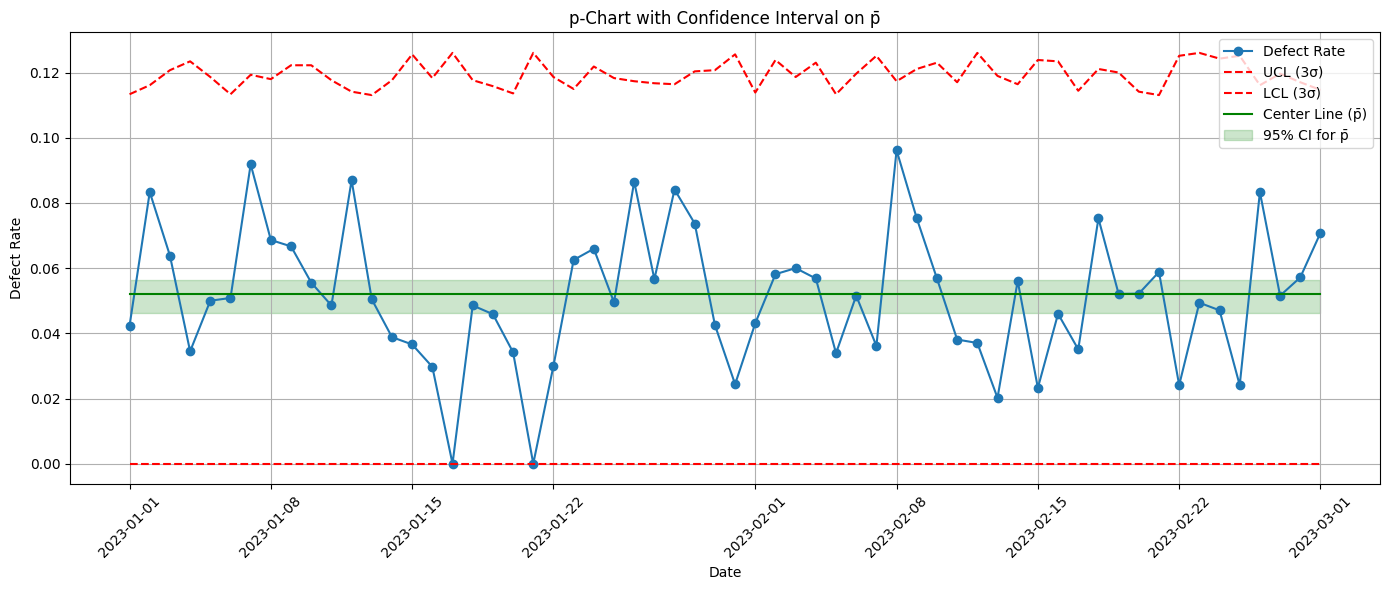

In [ ]:
# Existing chart
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')

# Add this for confidence interval shading
plt.fill_between(
    df['Date'], ci_lower, ci_upper,
    color='green', alpha=0.2, label='95% CI for p̄'
)

# Finalize chart
plt.title('p-Chart with Confidence Interval on p̄')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This p-chart shows the daily defect rate with control limits (red) and the average line (green). The shaded area represents the 95% confidence interval for the average defect rate (p̄), giving a range where the true average is likely to fall.


## What is Hypothesis Testing Over Time?

Hypothesis testing over time checks if changes in defect rates are real or just random. We start by assuming there’s no change. If the test shows a clear trend, we can confidently say the process is improving or getting worse. It helps track performance and guide decisions.


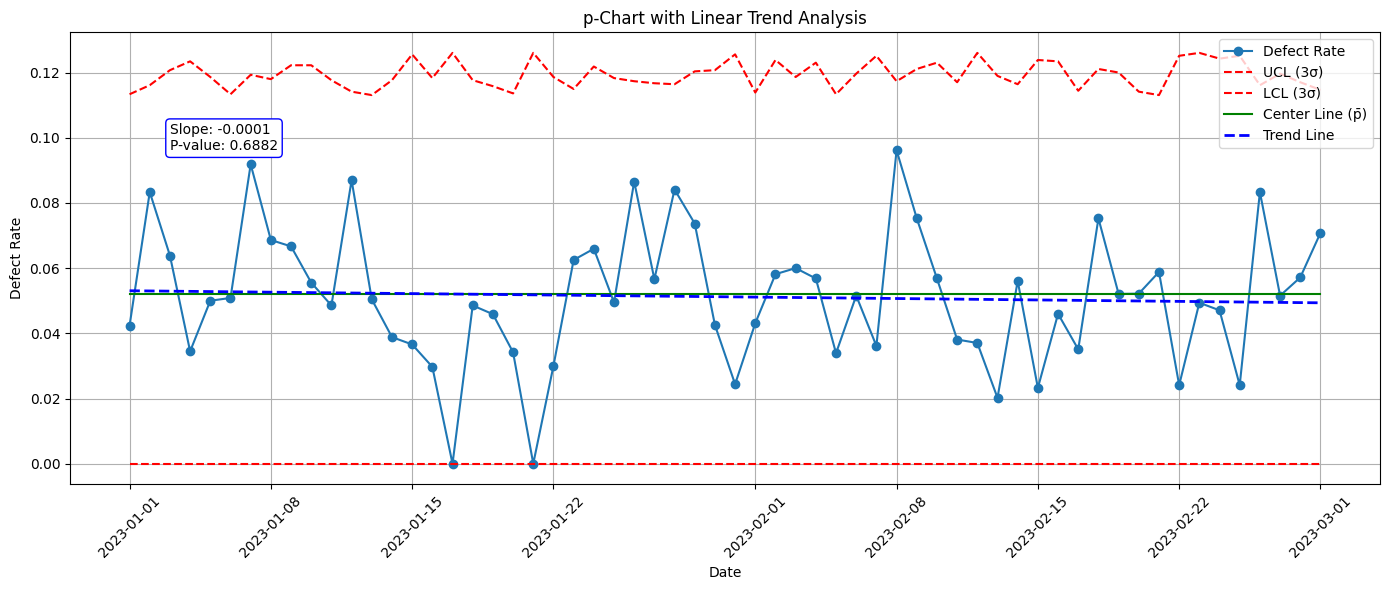

In [ ]:
from scipy.stats import linregress
import pandas as pd

# create Day dataframe
df['Day']=range(1,len(df)+1)
trend_result=linregress(df['Day'],df['Defect_Rate'])
slope=trend_result.slope
p_value=trend_result.pvalue
intercept=trend_result.intercept
df['Trend_Line']=intercept+slope*df['Day']

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Defect_Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')
plt.plot(df['Date'], df['Trend_Line'], linestyle='--', color='blue', linewidth=2, label='Trend Line')

plt.text(df['Date'].iloc[2], max(df['Defect_Rate']),
         f"Slope: {slope:.4f}\nP-value: {p_value:.4f}",
         fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round'))
plt.title('p-Chart with Linear Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This p-chart includes a blue trend line based on linear regression. It helps show if defect rates are steadily increasing or decreasing over time. The slope and p-value tell us how strong and significant the trend is.


## CUSUM Chart

A CUSUM chart helps detect small, steady changes in a process that regular p-charts might miss. It adds up the daily differences from the average:

* If defects are high, the line goes up.
* If defects are low, the line goes down.
* If stable, it stays near zero.

It’s great for spotting slow trends early—before they become serious problems.


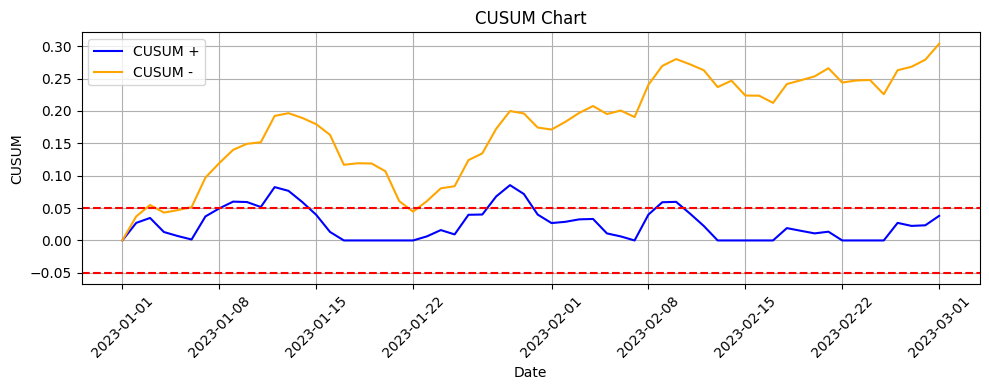

In [ ]:
target=df['Defect_Rate'].mean() #base line(center line)
k=0.005 #Reference value(senisitivity threshold)
h=0.05 #Decision threshold

#Intitialize lists
cusum_pos=[0]
cusum_neg=[0]

#Calculate CUSUM values
for i in range(1,len(df)):
  p_i=df.loc[i,'Defect_Rate'] #Everyday defect rate
  s_pos=max(0,cusum_pos[-1]+(p_i-target-k))
  s_neg=max(0,cusum_neg[-1]+(p_i-target+k))
  cusum_pos.append(s_pos)
  cusum_neg.append(s_neg)
df['CUSUM_pos']=cusum_pos
df['CUSUM_neg']=cusum_neg
# Plot CUSUM
plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['CUSUM_pos'], label='CUSUM +', color='blue')
plt.plot(df['Date'], df['CUSUM_neg'], label='CUSUM -', color='orange')
plt.axhline(h, color='red', linestyle='--')
plt.axhline(-h, color='red', linestyle='--')

plt.title('CUSUM Chart')
plt.xlabel('Date')
plt.ylabel('CUSUM')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This CUSUM chart shows small changes in defect rates over time. The blue and orange lines track positive and negative shifts from the average. If either line crosses the red threshold, it signals a possible change in the process.


## EWMA Chart

An EWMA chart tracks small, slow changes by giving more weight to recent data. It smooths out random noise and shows trends clearly.

Unlike p-charts (for big jumps) or CUSUM (for small build-ups), EWMA shows gradual drifts. It’s great for spotting early signs of rising defect rates over time.


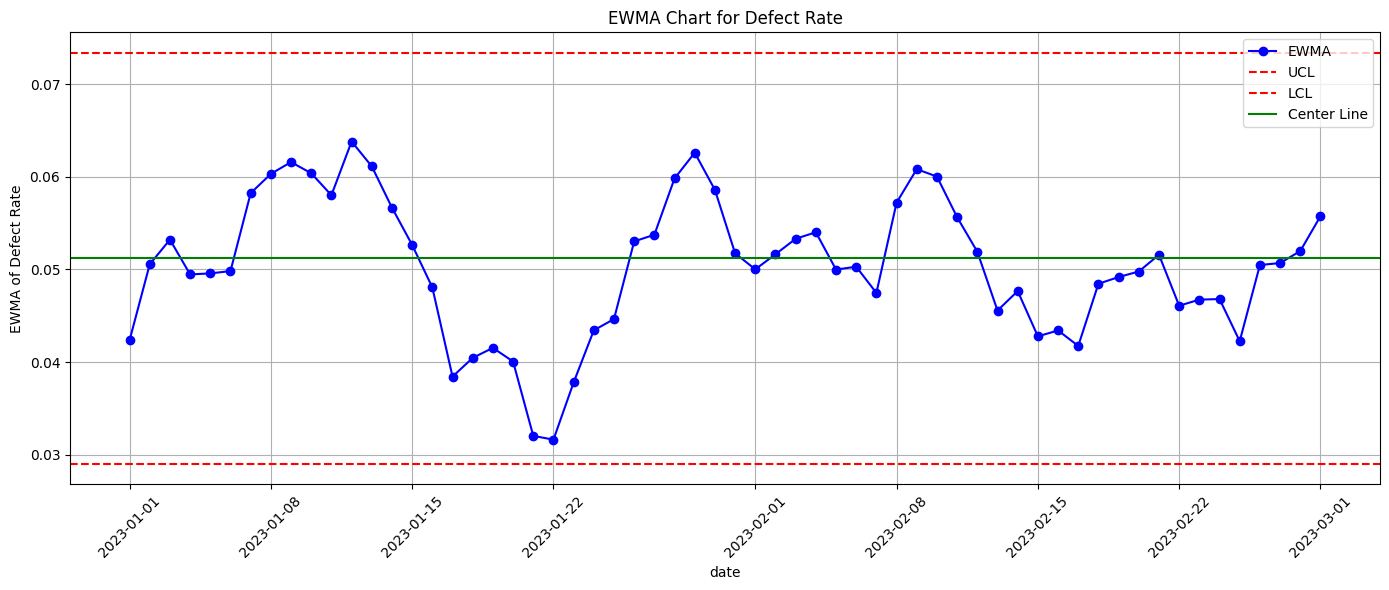

In [ ]:
# EWMA calculation
lam = 0.2
l = 3
df['EWMA'] = 0.0
df.loc[0, 'EWMA'] = df.loc[0, 'Defect_Rate']

for i in range(1, len(df)):
    df.loc[i, 'EWMA'] = lam * df.loc[i, 'Defect_Rate'] + (1 - lam) * df.loc[i - 1, 'EWMA']

# Control limits calculation
p_bar = df['Defect_Rate'].mean()
avg_n = df['Sample_Size'].mean()
sigma = np.sqrt((p_bar * (1 - p_bar)) / avg_n)

df['UCL'] = p_bar + l * sigma * np.sqrt(lam / (2 - lam))
df['LCL'] = p_bar - l * sigma * np.sqrt(lam / (2 - lam))
df['CL'] = p_bar

# Plotting the EWMA chart
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['EWMA'], marker='o', label='EWMA', color='blue')
plt.axhline(df['UCL'][0], color='red', linestyle='--', label='UCL')
plt.axhline(df['LCL'][0], color='red', linestyle='--', label='LCL')
plt.axhline(df['CL'][0], color='green', linestyle='-', label='Center Line')

plt.title('EWMA Chart for Defect Rate')
plt.xlabel('date')
plt.ylabel('EWMA of Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This EWMA chart smooths out daily defect rates to show small, gradual trends. The blue line is the EWMA, while the red dashed lines are control limits. If the EWMA moves outside these limits, it signals a possible process shift.


## KPI(Knowledge process indicator) Dashboard with matplotlib

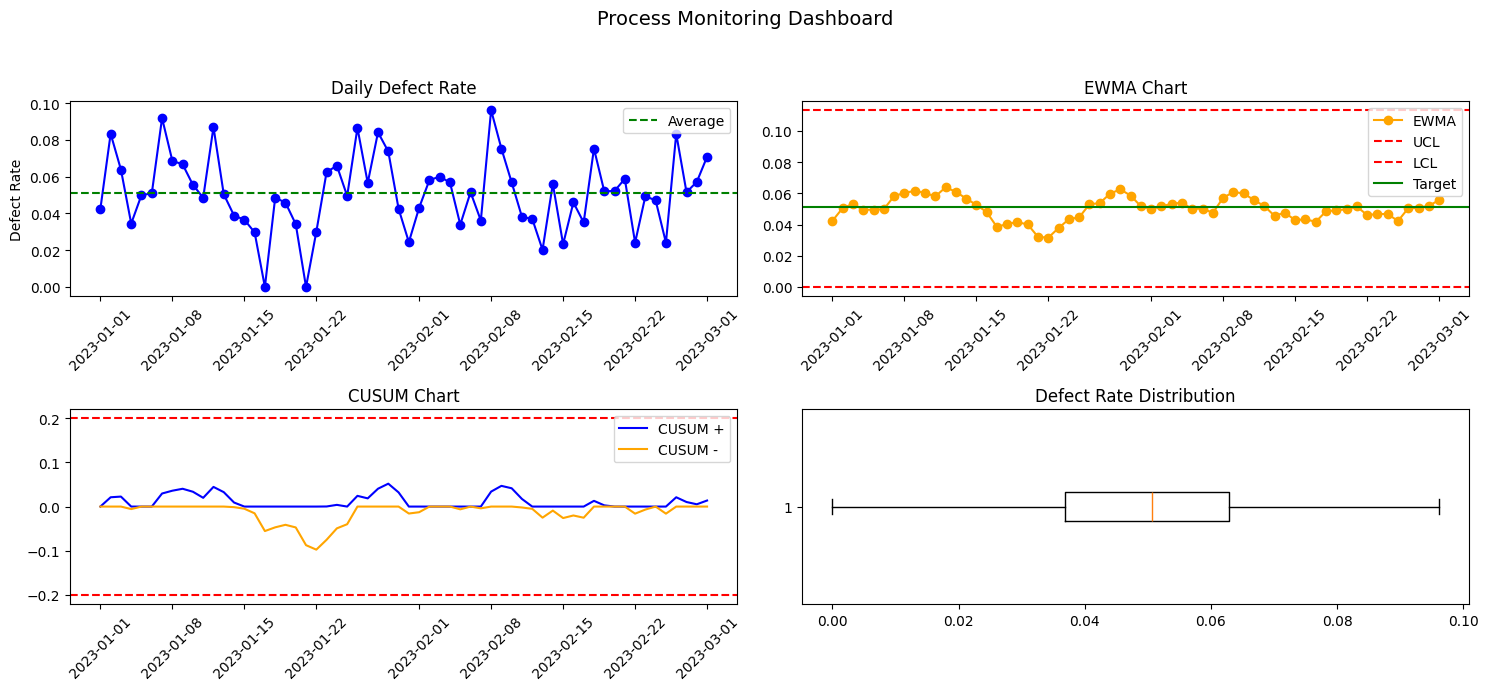

 Summary KPIs:
- Average Defect Rate: 0.0512
- Max Defect Rate:     0.0962
- Min Defect Rate:     0.0000
- Out-of-control Days (CUSUM): 0
- Days Monitored:      60

 Note: Control limits for Daily Chart use p̄ ± 3σ (based on overall avg and daily sample size - calculated earlier). EWMA λ = 0.2.


In [ ]:
# CUSUM Calculation
# Target defect rate (center line)
target_p = p_bar

# Reference value k (usually half the allowance delta, delta typically around 1 sigma)
# A common choice is k = 0.5 * sigma
k = 0.5 * sigma

# Initialize CUSUM columns
df['CUSUM_Pos'] = 0.0
df['CUSUM_Neg'] = 0.0

# Calculate CUSUM values
for i in range(len(df)):
    # Deviation from target
    deviation = df.loc[i, 'Defect_Rate'] - target_p

    # Positive CUSUM (detects increases)
    if i == 0:
        df.loc[i, 'CUSUM_Pos'] = max(0, deviation - k)
    else:
        df.loc[i, 'CUSUM_Pos'] = max(0, df.loc[i - 1, 'CUSUM_Pos'] + deviation - k)

    # Negative CUSUM (detects decreases)
    if i == 0:
        df.loc[i, 'CUSUM_Neg'] = min(0, deviation + k)
    else:
        df.loc[i, 'CUSUM_Neg'] = min(0, df.loc[i - 1, 'CUSUM_Neg'] + deviation + k)

# Now, recalculate out-of-control days using CUSUM with the threshold h
h = 0.2  # Decision interval threshold
out_of_control_days = df[(df['CUSUM_Pos'] > h) | (df['CUSUM_Neg'] < -h)].shape[0]

# The rest of the plotting code remains the same.
# KPI Calculations
average_defect_rate = df['Defect_Rate'].mean()
max_defect_rate = df['Defect_Rate'].max()
min_defect_rate = df['Defect_Rate'].min()

# Days monitored
days_monitored = len(df)

# Plot setup
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
fig.suptitle('Process Monitoring Dashboard', fontsize=14)

# --- Plot 1: Daily Defect Rate ---
axs[0, 0].plot(df['Date'], df['Defect_Rate'], marker='o', color='blue')
axs[0, 0].axhline(p_bar, color='green', linestyle='--', label='Average')
axs[0, 0].set_title('Daily Defect Rate')
axs[0, 0].set_ylabel('Defect Rate')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

# --- Plot 2: EWMA Chart ---
axs[0, 1].plot(df['Date'], df['EWMA'], marker='o', color='orange', label='EWMA')
axs[0, 1].axhline(df['UCL'][0], color='red', linestyle='--', label='UCL')
axs[0, 1].axhline(df['LCL'][0], color='red', linestyle='--', label='LCL')
axs[0, 1].axhline(p_bar, color='green', linestyle='-', label='Target')
axs[0, 1].set_title('EWMA Chart')
axs[0, 1].legend()
axs[0, 1].tick_params(axis='x', rotation=45)

# --- Plot 3: CUSUM Chart ---
axs[1, 0].plot(df['Date'], df['CUSUM_Pos'], label='CUSUM +', color='blue')
axs[1, 0].plot(df['Date'], df['CUSUM_Neg'], label='CUSUM -', color='orange')
axs[1, 0].axhline(h, color='red', linestyle='--')
axs[1, 0].axhline(-h, color='red', linestyle='--')
axs[1, 0].set_title('CUSUM Chart')
axs[1, 0].legend()
axs[1, 0].tick_params(axis='x', rotation=45)

# --- Plot 4: Boxplot ---
axs[1, 1].boxplot(df['Defect_Rate'], vert=False)
axs[1, 1].set_title('Defect Rate Distribution')

# Layout adjustments
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print KPIs
print(" Summary KPIs:")
print(f"- Average Defect Rate: {average_defect_rate:.4f}")
print(f"- Max Defect Rate:     {max_defect_rate:.4f}")
print(f"- Min Defect Rate:     {min_defect_rate:.4f}")
print(f"- Out-of-control Days (CUSUM): {out_of_control_days}")
print(f"- Days Monitored:      {days_monitored}")
print()
print(" Note: Control limits for Daily Chart use p̄ ± 3σ (based on overall avg and daily sample size - calculated earlier). EWMA λ = 0.2.")

## Conclusion

This project used p-chart, CUSUM, and EWMA charts to track defect rates in a factory process. At first, things looked stable, but from early February, defects started rising. The p-chart and trend line showed a clear upward pattern. The CUSUM chart caught small shifts building up, and the EWMA chart confirmed a steady rise past control limits. All charts point to the same issue: quality is going down, and action is needed to fix the process.
